# Laboratorium 3

### Konfiguracja

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [7]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


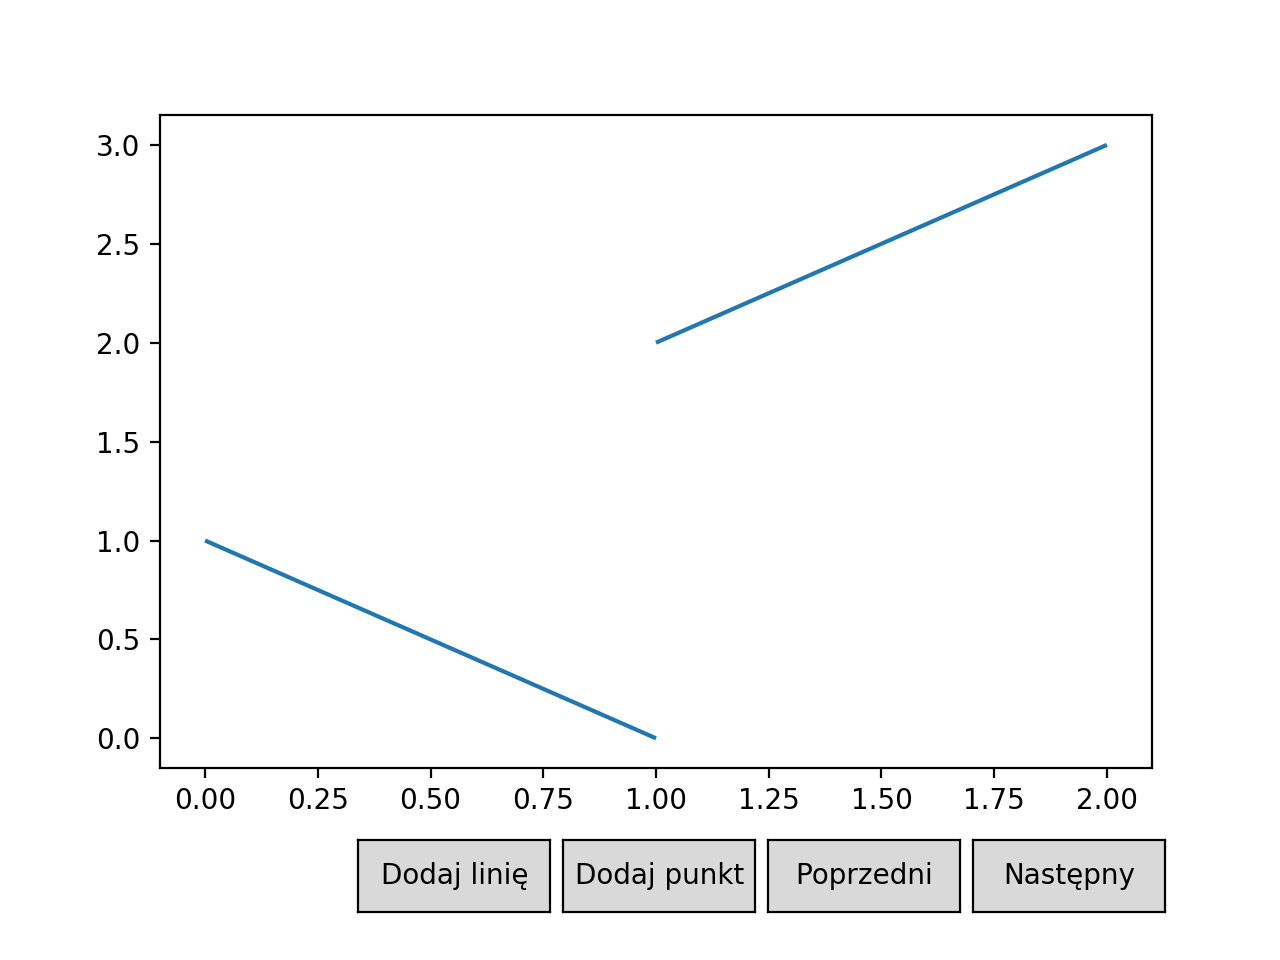

In [260]:
%matplotlib notebook

scenes=[Scene([PointsCollection()], [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])]

plot = Plot(scenes)
#plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

In [ ]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [ ]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

In [20]:
scenes = []

## 1.

In [382]:
%matplotlib notebook

def checkCond(X):
    wrong = []
    for i in range(len(X)):
        if X[i][0][0] == X[i][1][0]:
            wrong.append(X[i])
    for w in wrong:
        X.remove(w)
    return X

def randomLines(n, lowerLeft, upperRight):
    Lines = []
    for i in range(n):
        a = (random.uniform(lowerLeft[0], upperRight[0]), random.uniform(lowerLeft[1], upperRight[1]))
        b = (random.uniform(lowerLeft[0], upperRight[0]), random.uniform(lowerLeft[1], upperRight[1]))
        Lines.append([a,b])
        
    
    Lines = checkCond(Lines)
    scenes.append(Scene([PointsCollection()], [LinesCollection(Lines)]))
    return Lines
    
# def intLines(n, lowerLeft, upperRight):
#     Lines = []
#     for i in range(n):
#         a = (random.randrange(lowerLeft[0], upperRight[0]), random.randrange(lowerLeft[1], upperRight[1]))
#         b = (random.randrange(lowerLeft[0], upperRight[0]), random.randrange(lowerLeft[1], upperRight[1]))
#         Lines.append([a,b])


#     Lines = checkCond(Lines)
#     return Lines

def parLines(n, lowerLeft, upperRight):
    Lines = []
    for i in range(n):
        t1 = random.uniform(lowerLeft[1], upperRight[1])
        a = (random.uniform(lowerLeft[0], upperRight[0]), t1)
        b = (random.uniform(lowerLeft[0], upperRight[0]), t1)
        Lines.append([a,b])
    return Lines


# plot = Plot(scenes)
# plot.draw()

## 2. Wykrywanie istnienia przecięcia

In [290]:
from sortedcontainers import SortedList

def do_intersect(segments, corners, scenes=[]):
    class Point:
        def __init__(self, crd, ptype, other_end):
            self.x = crd[0]
            self.y = crd[1]
            self.ptype = ptype # 0 - left, 1 - right, 2 - intersection
            self.other_end = other_end
    
    
    q1 = [Point(s[0], 0, s[1]) if s[0][0] <= s[1][0] else Point(s[0], 1, s[1]) for s in segments]
    q2 = [Point(s[1], 0, s[0]) if s[1][0] <= s[0][0] else Point(s[1], 1, s[0]) for s in segments]
    Q = q1 + q2
    Q = SortedList(Q, key = lambda x: x.x)
    
    
    T = SortedList(key = lambda x: x.y)                              #sweep status structure
    
    def prd(p):
        if T.index(p) == 0:
            return False
        else:
            return T.__getitem__(T.index(p)-1)
        
    def ssc(p):
        if T.index(p) == T.__len__()-1:
            return False
        else:
            return T.__getitem__(T.index(p)+1)
        
    def remove_seg(p):
        e = Point(p.other_end, 0, (p.x,p.y))
        for j in range(T.__len__()):
            i = T.__getitem__(j)
            if i.x == e.x and i.y == e.y and e.other_end == i.other_end:
                T.__delitem__(j)   
                break
                
    def intersect(a,b):
        def orient(a,b,c):
            m = [a[0], a[1], b[0], b[1], c[0], c[1]]
            det = np.linalg.det(np.concatenate((np.reshape(m, (3, 2)), np.ones((3,1))), axis=1))
            if det == 0:
                return 0
            elif det > 0:
                return 1
            else:
                return 2
        a1 = (a.x,a.y)
        b1 = (b.x,b.y)
        a2 = a.other_end
        b2 = b.other_end
        d1 = orient(b1, b2, a1)
        d2 = orient(b1, b2, a2)
        d3 = orient(a1, a2, b1)
        d4 = orient(a1, a2, b2)
        if d1 != d2 and d3 != d4:
            return True
        else:
            return False
    
    crossed = False
    while Q.__len__() > 0:
        p = Q.pop(0)
        
        scenes.append(Scene([PointsCollection([])],[ LinesCollection(segments), LinesCollection([ [(p.x, corners[0][1]), (p.x, corners[1][1])] ], color='Red')]))
        
        if p.ptype == 0:
            T.add(p)
            if(prd(p)):
                if intersect(p, prd(p)):
                    crossed = True
            if(ssc(p)):
                if intersect(p, ssc(p)):
                    crossed = True
        elif p.ptype == 1:
            T.add(p)
            if prd(p) and ssc(p):
                if intersect(prd(p), ssc(p)):
                    crossed = True
            remove_seg(p)

    return crossed

Yes


<IPython.core.display.Javascript object>


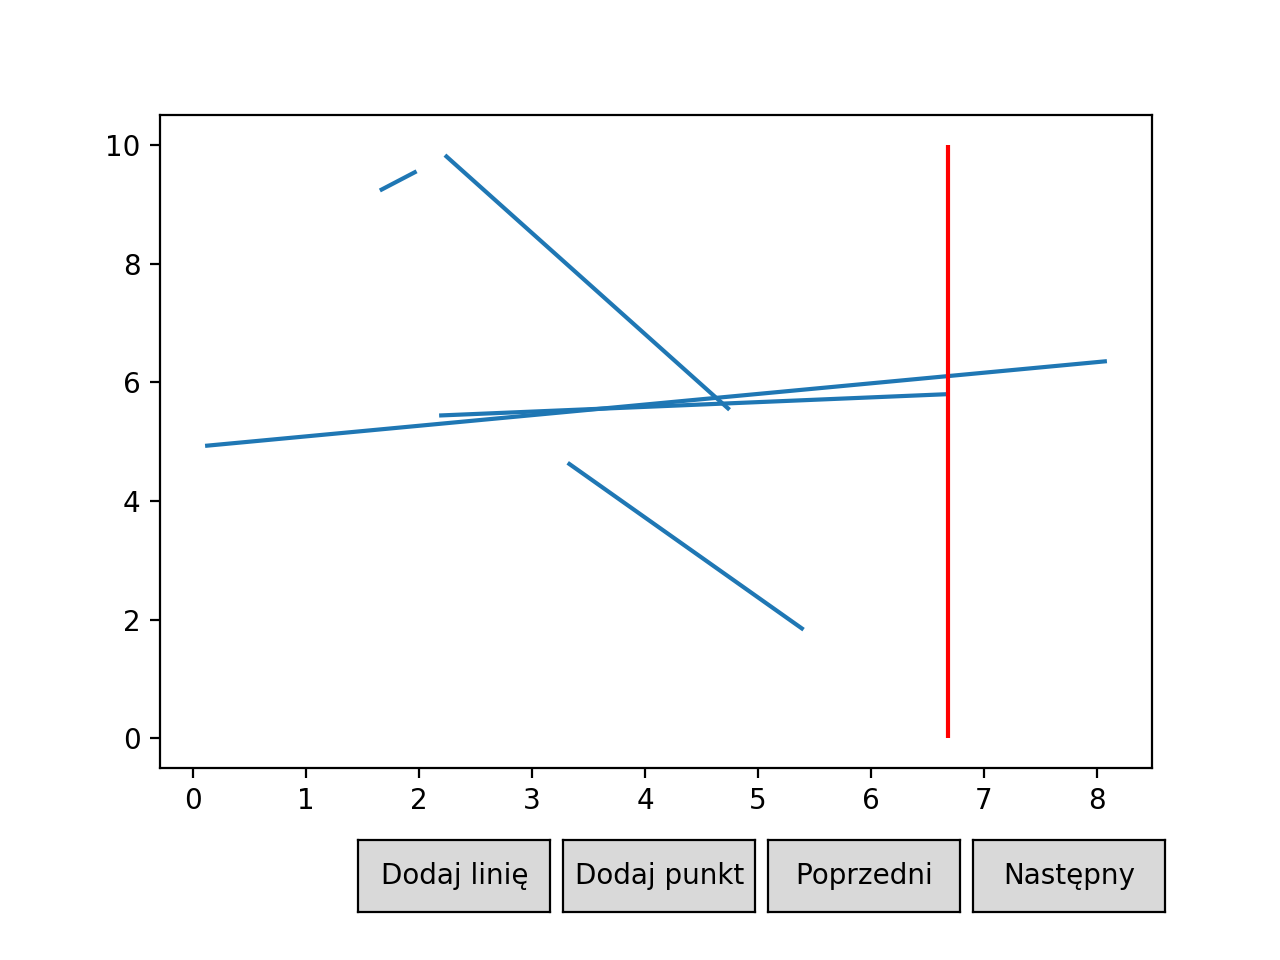

In [294]:
#test simple sweep
corners = [(0,0), (10,10)]
scenes = []

x = randomLines(5, corners[0], corners[1])
#x = parlines(5, corners[0], corners[1])

scenes = [Scene( [PointsCollection()], [LinesCollection(x)])]

if do_intersect(x, corners, scenes):
    print("Yes")
else:
    print("No")
    
plot = Plot(scenes)
plot.draw()

## 6. Wypisywanie przecięć

In [380]:
from sortedcontainers import SortedList

def intersections(segments, corners, scenes=[]):
    class Point:
        def __init__(self, crd, ptype, other_end):
            self.x = crd[0]
            self.y = crd[1]
            self.ptype = ptype # 0 - left, 1 - right, 2 - intersection
            self.other_end = other_end
    
    
    q1 = [Point(s[0], 0, s[1]) if s[0][0] <= s[1][0] else Point(s[0], 1, s[1]) for s in segments]
    q2 = [Point(s[1], 0, s[0]) if s[1][0] <= s[0][0] else Point(s[1], 1, s[0]) for s in segments]
    Q = q1 + q2
    Q = SortedList(Q, key = lambda x: x.x)
    
    
    T = SortedList(key = lambda x: x.y)                              #sweep status structure
    
    def prd(p):
        if T.index(p) == 0:
            return False
        else:
            return T.__getitem__(T.index(p)-1)
        
    def ssc(p):
        if T.index(p) == T.__len__()-1:
            return False
        else:
            return T.__getitem__(T.index(p)+1)
        
    def find(p,other = True):
        if other == True:
            e = Point(p.other_end, 0, (p.x,p.y))
        else:
            e = p
        for j in range(T.__len__()):
            i = T.__getitem__(j)
            if i.x == e.x and i.y == e.y and e.other_end == i.other_end:
                return (True, j)
                
    def intersect(a,b):
        def orient(a,b,c):
            m = [a[0], a[1], b[0], b[1], c[0], c[1]]
            det = np.linalg.det(np.concatenate((np.reshape(m, (3, 2)), np.ones((3,1))), axis=1))
            if det == 0:
                return 0
            elif det > 0:
                return 1
            else:
                return 2
        a1 = (a.x,a.y)
        b1 = (b.x,b.y)
        a2 = a.other_end
        b2 = b.other_end
        d1 = orient(b1, b2, a1)
        d2 = orient(b1, b2, a2)
        d3 = orient(a1, a2, b1)
        d4 = orient(a1, a2, b2)
        if d1 != d2 and d3 != d4:
            return True
        else:
            return False
        
    def common_point(x,y):
        A = (x.x,x.y)
        B = x.other_end
        C = (y.x, y.y)
        D = y.other_end
        a1 = np.array([[1,A[0]],[1,B[0]]])
        b1 = np.array([A[1],B[1]])
        a2 = np.array([[1,C[0]],[1,D[0]]])
        b2 = np.array([C[1],D[1]])
        s1 = np.linalg.solve(a1, b1)
        s2 = np.linalg.solve(a2, b2)
        return ((s2[0]-s1[0])/(s1[1]-s2[1]), (s1[1]*s2[0]-s1[0]*s2[1])/(s1[1]-s2[1]))       
    
    crossings = []
    while Q.__len__() > 0:
        p = Q.pop(0)
        
        col = 'Red'
        
        if p.ptype == 0:
            T.add(p)
            if(prd(p)):
                if intersect(p, prd(p)):
                    c = common_point(p,prd(p))
                    crossings.append(c)
                    Q.add(Point(c,2,()))
            if(ssc(p)):
                if intersect(p, ssc(p)):
                    c = common_point(p,ssc(p))
                    crossings.append(c)
                    Q.add(Point(c,2,()))
        elif p.ptype == 1:
            T.add(p)
            if prd(p) and ssc(p):
                if intersect(prd(p), ssc(p)):
                    c = common_point(prd(p),ssc(p))
                    crossings.append(c)
                    if not find(Point(c,2,()), False):
                        Q.add(Point(c,2,()))
            if find(p)[0]:
                T.__delitem__(find(p)[1])
        else:
            col = 'Yellow'
            
        scenes.append(Scene([PointsCollection([])],[ LinesCollection(segments), LinesCollection([ [(p.x, corners[0][1]), (p.x, corners[1][1])] ], color=col)]))

    return (len(crossings), crossings)

<IPython.core.display.Javascript object>


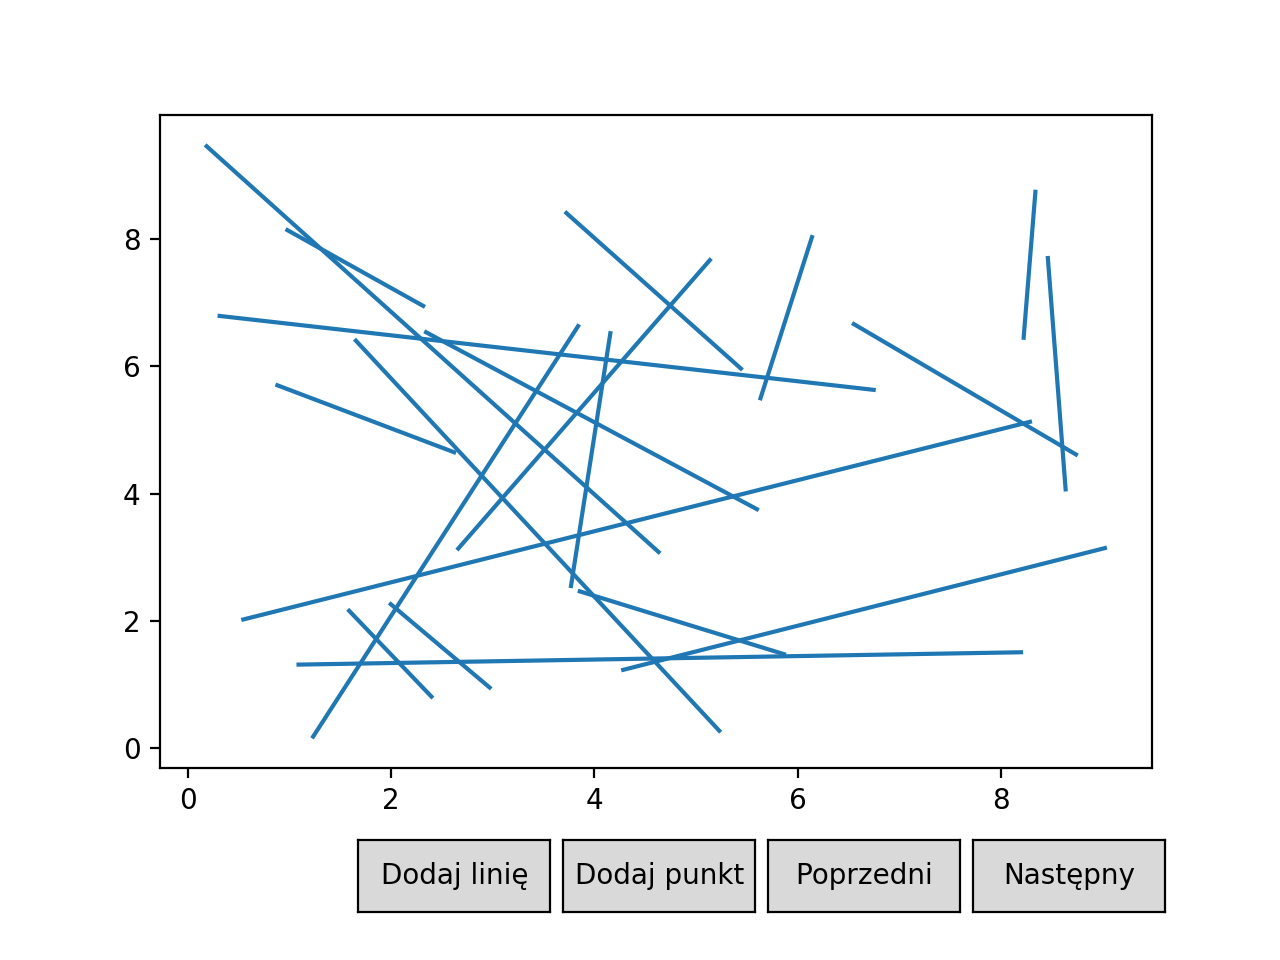

11
(2.294042582767757, 6.434998085269405)
(1.3091270149137726, 7.848244444740257)
(1.6967339644705786, 1.326252404857441)
(2.5077481746253145, 6.396398040788052)
(1.6967339644705786, 1.326252404857441)
(2.078495713534413, 1.3366675475404237)
(3.8476762461603737, 3.345590918781712)
(4.08052090403847, 5.736526660952024)
(2.5077481746253145, 6.396398040788052)
(3.426951169029862, 5.61062335741697)
(4.733364855304906, 1.4090971217028263)


In [405]:
#test sweep with coordinates
corners = [(0,0), (10,10)]
scenes = []

x = randomLines(20, corners[0], corners[1])
#x = parLines(20, corners[0], corners[1])

scenes = [Scene( [PointsCollection()], [LinesCollection(x)])]

res = intersections(x, corners, scenes)
    
plot = Plot(scenes)
plot.draw()
print(res[0])
for i in res[1]:
    print(i)